In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier

import polars as pl

train = pl.read_csv("./data/train_v2.csv")

transactions = pl.read_csv("./data/transactions_v2.csv")

user_logs = pl.read_csv("./data/user_logs_v2.csv")

members = pl.read_csv("./data/members_v3.csv")


print(train.shape, transactions.shape, user_logs.shape, members.shape)


train = train.to_pandas()
transactions = transactions.to_pandas()
user_logs = user_logs.to_pandas()
members = members.to_pandas()

(970960, 2) (1431009, 9) (18396362, 9) (6769473, 6)


### train(라벨값) 통계 보기.

In [3]:
train.head(3)

msno,is_churn
str,i64
"""ugx0CjOMzazClkFzU2xasmDZaoIqOU…",1
"""f/NmvEzHfhINFEYZTR05prUdr+E+3+…",1
"""zLo9f73nGGT1p21ltZC3ChiRnAVvgi…",1


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   msno      970960 non-null  object
 1   is_churn  970960 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 14.8+ MB


In [10]:
print(train['is_churn'].value_counts(normalize=True))
print(train['is_churn'].value_counts())

is_churn
0    0.910058
1    0.089942
Name: proportion, dtype: float64
is_churn
0    883630
1     87330
Name: count, dtype: int64


In [26]:
import pickle
train.to_pickle("./preprocessingdata/train_v2")

### transactions 통계 보기

In [9]:
transactions.head(3)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   msno                    1431009 non-null  object
 1   payment_method_id       1431009 non-null  int64 
 2   payment_plan_days       1431009 non-null  int64 
 3   plan_list_price         1431009 non-null  int64 
 4   actual_amount_paid      1431009 non-null  int64 
 5   is_auto_renew           1431009 non-null  int64 
 6   transaction_date        1431009 non-null  int64 
 7   membership_expire_date  1431009 non-null  int64 
 8   is_cancel               1431009 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 98.3+ MB


transactions 데이터프레임
-  5   is_auto_renew           1431009 non-null  int64  -> 용량 줄이기
-  6   transaction_date        1431009 non-null  int64  -> datetime으로 형변환해주기
-  7   membership_expire_date  1431009 non-null  int64  -> datetime으로 형변환해주기
-  8   is_cancel               1431009 non-null  int64  -> 용량 줄이기

In [13]:
# 0/1 컬럼 → int8로 변환 (메모리 절약)
transactions["is_auto_renew"] = transactions["is_auto_renew"].astype("int8")
transactions["is_cancel"] = transactions["is_cancel"].astype("int8")

transactions["transaction_date"] = pd.to_datetime(
    transactions["transaction_date"].astype(str),
    format="%Y%m%d"
)

transactions["membership_expire_date"] = pd.to_datetime(
    transactions["membership_expire_date"].astype(str),
    format="%Y%m%d"
)

In [22]:
# 남은 이용기간 변수 하나 생성
transactions["membership_duration"] = (
    transactions["membership_expire_date"]
    - transactions["transaction_date"]
).dt.days

변환 이후!

In [23]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   msno                    1431009 non-null  object        
 1   payment_method_id       1431009 non-null  int64         
 2   payment_plan_days       1431009 non-null  int64         
 3   plan_list_price         1431009 non-null  int64         
 4   actual_amount_paid      1431009 non-null  int64         
 5   is_auto_renew           1431009 non-null  int8          
 6   transaction_date        1431009 non-null  datetime64[ns]
 7   membership_expire_date  1431009 non-null  datetime64[ns]
 8   is_cancel               1431009 non-null  int8          
 9   membership_duration     1431009 non-null  int64         
dtypes: datetime64[ns](2), int64(5), int8(2), object(1)
memory usage: 90.1+ MB


### 유저 로그 보기

In [27]:
user_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18396362 entries, 0 to 18396361
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   msno        object 
 1   date        int64  
 2   num_25      int64  
 3   num_50      int64  
 4   num_75      int64  
 5   num_985     int64  
 6   num_100     int64  
 7   num_unq     int64  
 8   total_secs  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 1.2+ GB


In [10]:
user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [6]:
user_logs.describe(include='all')

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,18396362,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07
unique,1103894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,b74Xot5HcOL8YQGiuwLw+Cm7RyGV2fOkGczJomGLocg=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.017032e+07,6.191401e+00,1.508789e+00,9.413759e-01,1.079905e+00,3.028246e+01,2.903615e+01,7.904814e+03
std,NaN,8.916720e+00,1.342827e+01,3.908539e+00,1.924840e+00,3.518409e+00,4.203641e+01,3.219866e+01,1.013632e+04
min,NaN,2.017030e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-03
25%,NaN,2.017031e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,8.000000e+00,1.959944e+03
50%,NaN,2.017032e+07,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,1.800000e+01,4.582990e+03
75%,NaN,2.017032e+07,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.700000e+01,3.800000e+01,9.848441e+03


In [34]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   msno                    object
 1   city                    int64 
 2   bd                      int64 
 3   gender                  object
 4   registered_via          int64 
 5   registration_init_time  int64 
dtypes: int64(4), object(2)
memory usage: 309.9+ MB


In [7]:
members.describe(include='all')

,msno,city,bd,gender,registered_via,registration_init_time
count,6769473,6.769473e+06,6.769473e+06,2339968,6.769473e+06,6.769473e+06
unique,6769473,NaN,NaN,2,NaN,NaN
top,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,NaN,NaN,male,NaN,NaN
freq,1,NaN,NaN,1195355,NaN,NaN
mean,NaN,3.847358e+00,9.795794e+00,NaN,5.253069e+00,2.014518e+07
std,NaN,5.478359e+00,1.792590e+01,NaN,2.361398e+00,2.318601e+04
min,NaN,1.000000e+00,-7.168000e+03,NaN,-1.000000e+00,2.004033e+07
25%,NaN,1.000000e+00,0.000000e+00,NaN,4.000000e+00,2.014042e+07
50%,NaN,1.000000e+00,0.000000e+00,NaN,4.000000e+00,2.015101e+07
75%,NaN,4.000000e+00,2.100000e+01,NaN,7.000000e+00,2.016060e+07


In [29]:


# =========================================================
# 2) msno 기준 간단 집계
# =========================================================

# transactions 단순 집계
txn_agg = transactions.groupby("msno").agg(
    txn_cnt=("transaction_date", "count"),
    total_paid=("actual_amount_paid", "sum"),
    avg_paid=("actual_amount_paid", "mean"),
    avg_plan_days=("payment_plan_days", "mean"),
    auto_renew_rate=("is_auto_renew", "mean"),
    cancel_rate=("is_cancel", "mean"),
    total_cancel=("is_cancel", "sum"),
    avg_duration=("membership_duration", "mean"),
    max_duration=("membership_duration", "max"),
).reset_index()

# user_logs 숫자 통계값 활용.
log_agg = user_logs.groupby("msno").agg(
    total_secs_sum=("total_secs", "sum"),
    total_secs_mean=("total_secs", "mean"),
    num_unq_mean=("num_unq", "mean"),
    num_100_sum=("num_100", "sum"),
    num_985_sum=("num_985", "sum"),
    num_75_sum=("num_75", "sum"),
    num_50_sum=("num_50", "sum"),
    num_25_sum=("num_25", "sum"),
).reset_index()

# =========================================================
# 3) train이 unique한 값을 가지고 있으므로 msno 기준 left join
# =========================================================
df = train.merge(txn_agg, on="msno", how="left")
df = df.merge(log_agg, on="msno", how="left")
df = df.merge(members, on="msno", how="left")


print("After merge:", df.shape)




After merge: (970960, 24)


### 통합 데이터에서 나이 결측치 처리(bd)

In [55]:
import pickle
import pandas as pd
df = pd.read_pickle("./data/kkbox.pkl")


In [56]:
pd.set_option('display.max_columns', None)
df.describe()

,is_churn,txn_cnt,total_paid,avg_paid,avg_plan_days,auto_renew_rate,cancel_rate,total_cancel,avg_duration,max_duration,total_secs_sum,total_secs_mean,num_unq_mean,num_100_sum,num_985_sum,num_75_sum,num_50_sum,num_25_sum,city,bd,registered_via,registration_init_time
count,970960.000000,933578.000000,933578.000000,933578.000000,933578.000000,933578.000000,933578.000000,933578.000000,933578.000000,933578.000000,9.709600e+05,754551.000000,754551.000000,754551.000000,754551.000000,754551.000000,754551.000000,754551.000000,860967.000000,860967.000000,860967.000000,8.609670e+05
mean,0.089942,1.212578,175.852756,143.761684,33.668171,0.912116,0.021076,0.035223,40.477305,42.346501,1.397844e+05,6471.710507,24.323859,535.902252,18.713420,16.545723,26.257260,108.773786,5.937295,13.583854,6.892744,2.013265e+07
std,0.286099,1.285981,231.843859,133.723976,31.539039,0.281911,0.123174,0.187933,64.148371,76.145095,1.635475e+05,6419.715852,20.105340,763.731803,41.691069,22.399375,38.707599,179.003032,6.441203,20.064040,1.937794,3.011174e+04
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,-3.000000,3.500000e-02,0.035000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-3152.000000,3.000000,2.004033e+07
25%,0.000000,1.000000,99.000000,99.000000,30.000000,1.000000,0.000000,0.000000,30.000000,30.000000,4.310920e+04,2858.342125,11.937500,108.000000,3.000000,3.000000,5.000000,19.000000,1.000000,0.000000,7.000000,2.012021e+07
50%,0.000000,1.000000,149.000000,149.000000,30.000000,1.000000,0.000000,0.000000,31.000000,31.000000,1.268965e+05,4709.031167,19.233333,305.000000,10.000000,10.000000,14.000000,55.000000,1.000000,0.000000,7.000000,2.014060e+07
75%,0.000000,1.000000,149.000000,149.000000,30.000000,1.000000,0.000000,0.000000,31.000000,31.000000,1.407946e+05,7711.914108,30.210526,660.000000,23.000000,22.000000,33.000000,133.000000,13.000000,27.000000,9.000000,2.016012e+07
max,1.000000,208.000000,13650.000000,2000.000000,450.000000,1.000000,1.000000,8.000000,2118.795918,2796.000000,1.433739e+07,477913.045567,1560.200000,57675.000000,15164.000000,1310.000000,3163.000000,46820.000000,22.000000,2016.000000,13.000000,2.017042e+07


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    970960 non-null  object 
 1   is_churn                970960 non-null  int64  
 2   txn_cnt                 933578 non-null  float64
 3   total_paid              933578 non-null  float64
 4   avg_paid                933578 non-null  float64
 5   avg_plan_days           933578 non-null  float64
 6   auto_renew_rate         933578 non-null  float64
 7   cancel_rate             933578 non-null  float64
 8   total_cancel            933578 non-null  float64
 9   avg_duration            933578 non-null  float64
 10  max_duration            933578 non-null  float64
 11  total_secs_sum          970960 non-null  float64
 12  total_secs_mean         754551 non-null  float64
 13  num_unq_mean            754551 non-null  float64
 14  num_100_sum         

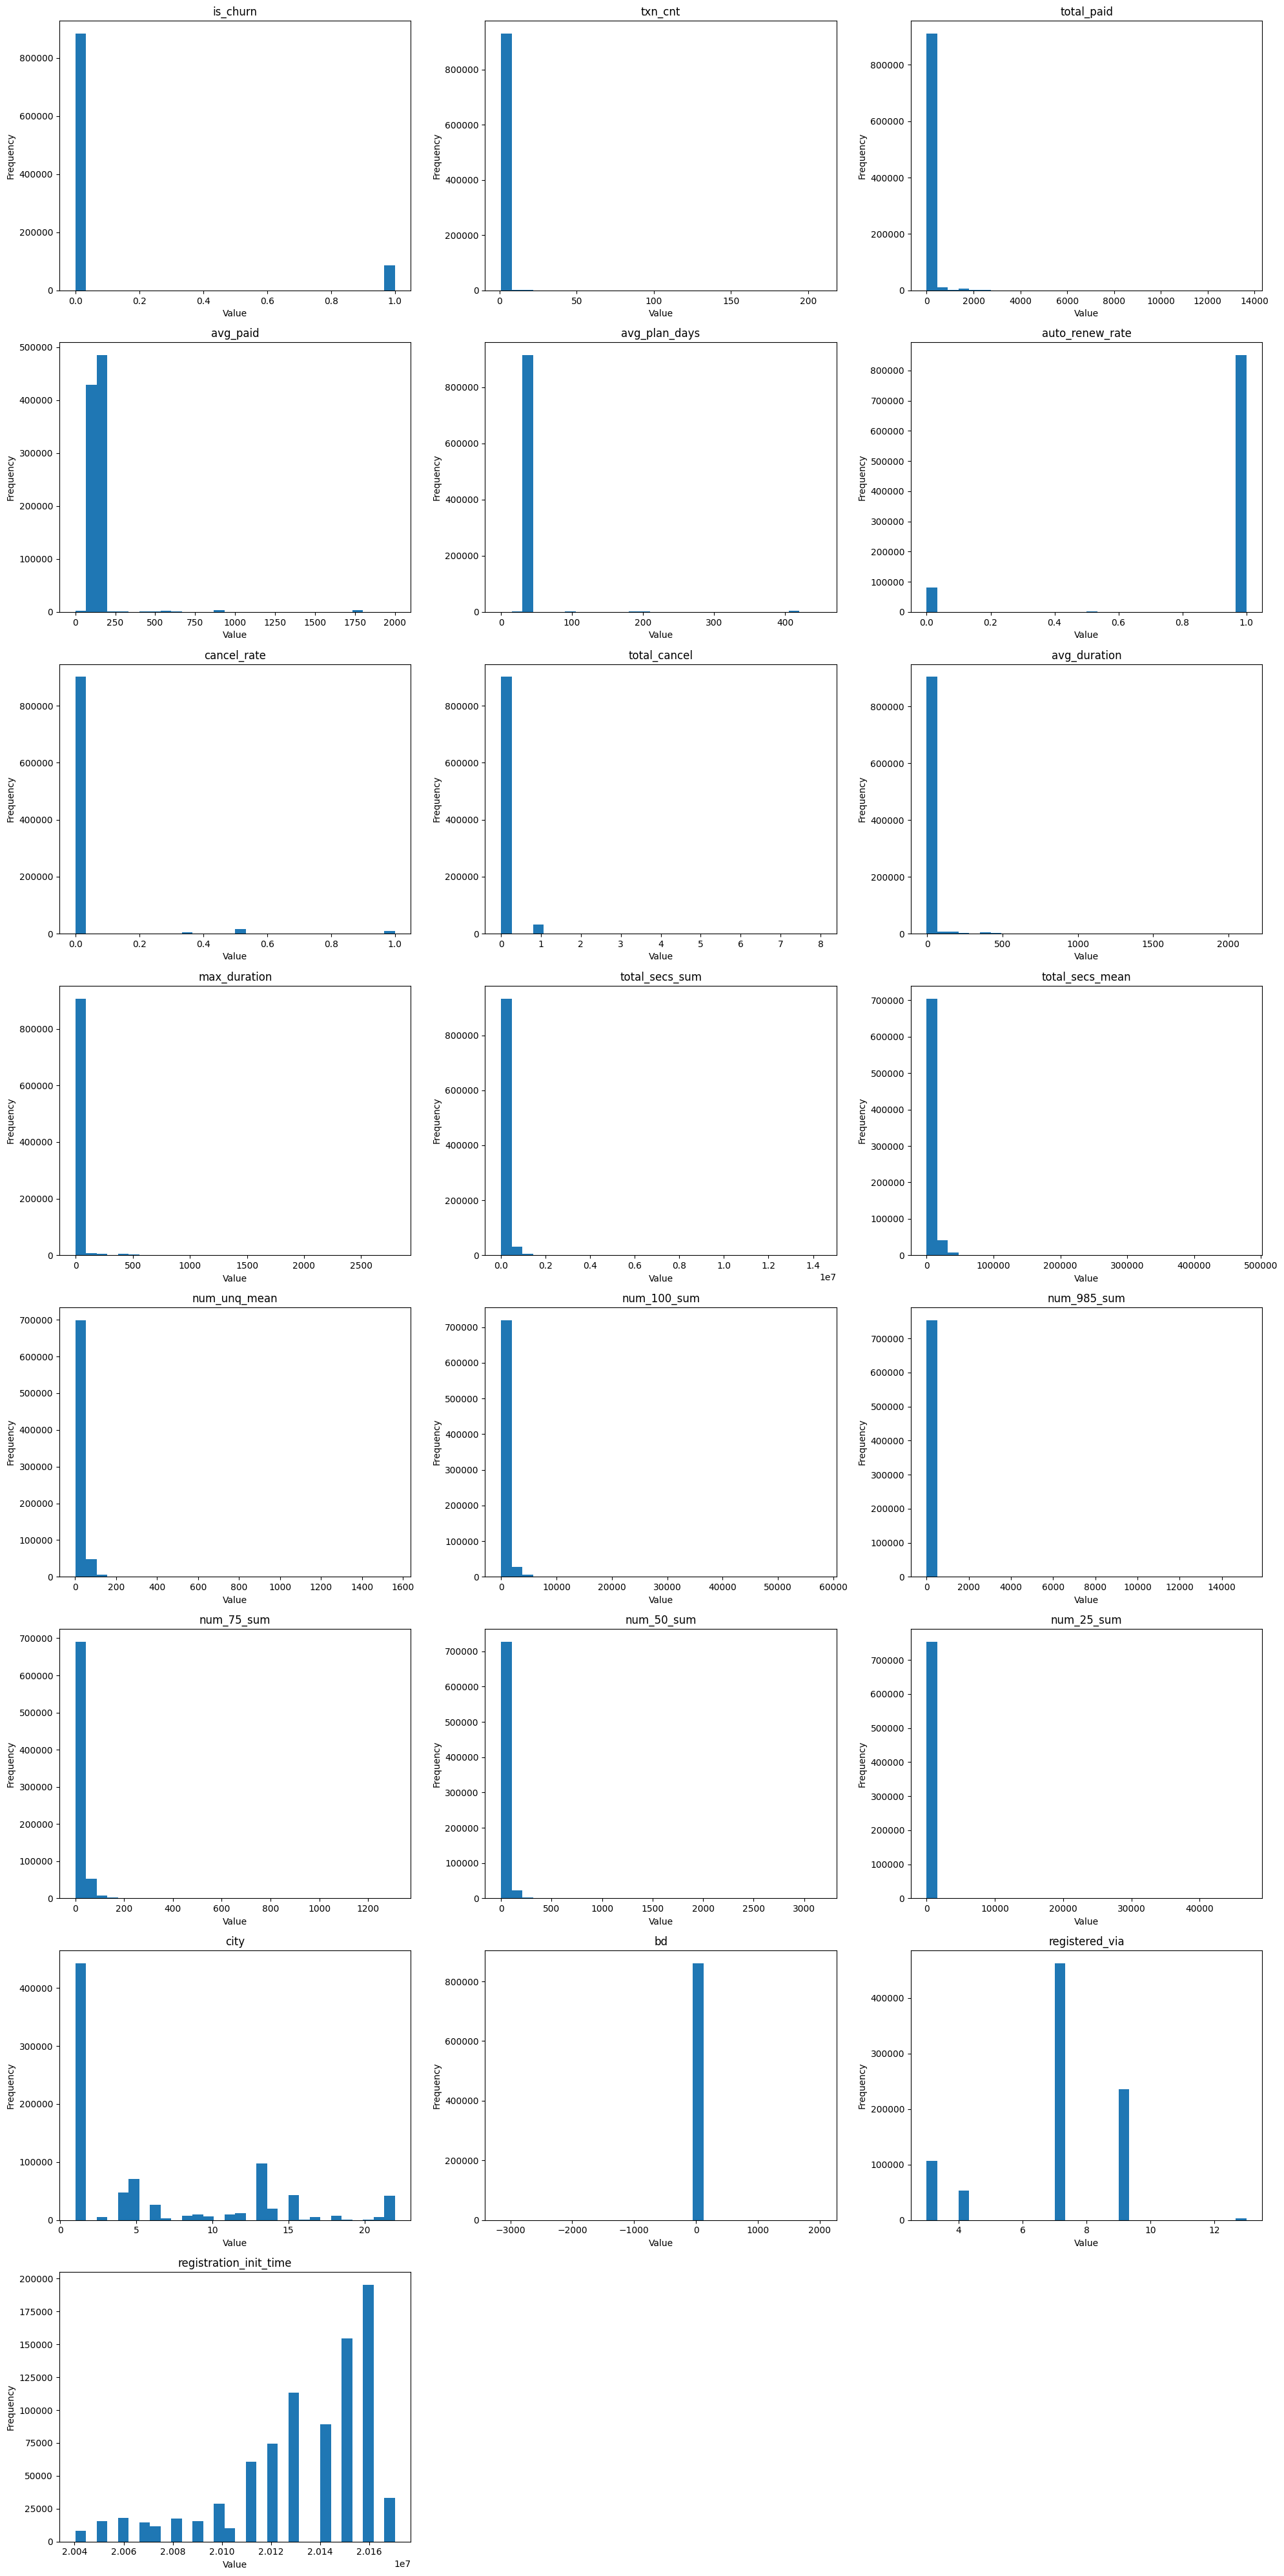

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 수치형 컬럼만 선택
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

n_cols = 3 # 한 줄에 4개씩
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=30)
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# 남는 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\Users\rosie\AppData\Local\Temp\ipykernel_22536\3221222656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(
C:\Users\rosie\AppData\Local\Temp\ipykernel_22536\3221222656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(
C:\Users\rosie\AppData\Local\Temp\ipykernel_22536\3221222656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(
C:\Users\rosie\AppData\Local\Temp\ipykernel_22536\3221222656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3

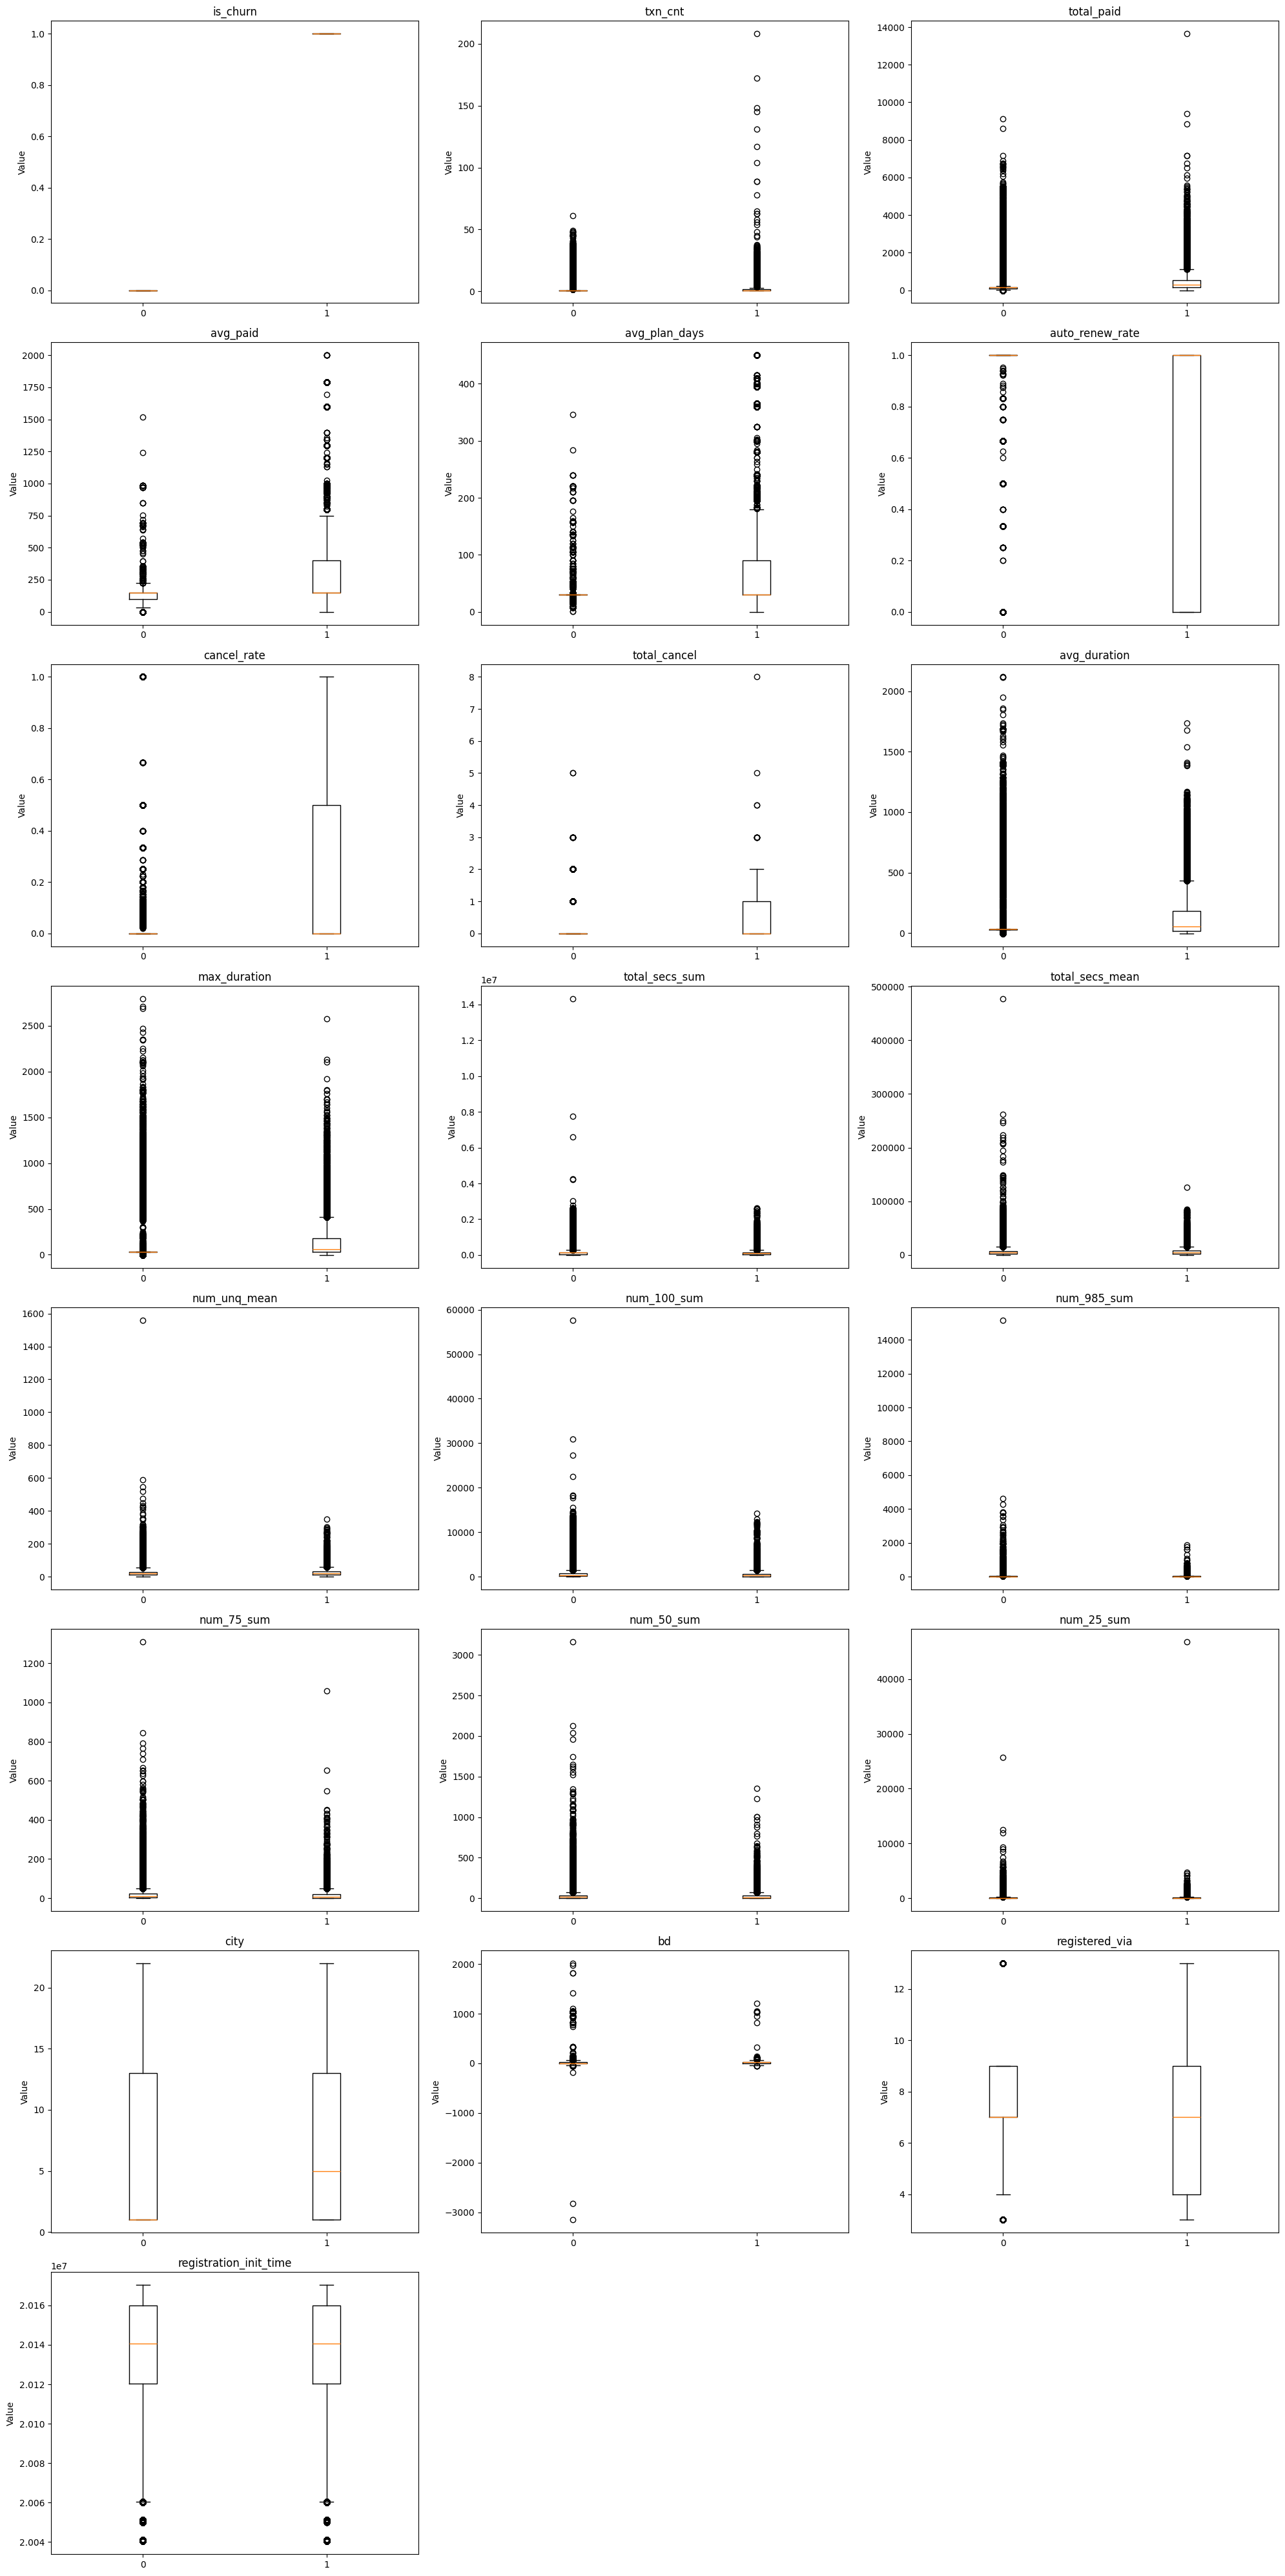

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 수치형 컬럼만 선택
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].boxplot(
        [
            df[df["is_churn"] == 0][col].dropna(),
            df[df["is_churn"] == 1][col].dropna()
        ],
        labels=["0", "1"]
    )
    axes[i].set_title(col)
    axes[i].set_ylabel("Value")

# 남는 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [57]:
df['bd'].describe()

count    860967.000000
mean         13.583854
std          20.064040
min       -3152.000000
25%           0.000000
50%           0.000000
75%          27.000000
max        2016.000000
Name: bd, dtype: float64

In [58]:
# 1) 유효 범위만 남기고 나머지는 NaN 처리
df["bd"] = df["bd"].where((df["bd"] >= 0) & (df["bd"] <= 100))

# 2) 결측치 비율 확인
print("Missing ratio:", df["bd"].isna().mean())

Missing ratio: 0.11382137266210761


In [59]:
bins = [15, 20, 30, 40, 50, 60, 70, 80]
labels = ["10s", "20s", "30s", "40s", "50s", "60s", "70s"]

df["age_group"] = pd.cut(df["bd"], bins=bins, labels=labels)

In [60]:
df["age_group"] = df["age_group"].cat.add_categories("unknown")
df["age_group"] = df["age_group"].fillna("unknown")

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   msno                    970960 non-null  object  
 1   is_churn                970960 non-null  int64   
 2   txn_cnt                 933578 non-null  float64 
 3   total_paid              933578 non-null  float64 
 4   avg_paid                933578 non-null  float64 
 5   avg_plan_days           933578 non-null  float64 
 6   auto_renew_rate         933578 non-null  float64 
 7   cancel_rate             933578 non-null  float64 
 8   total_cancel            933578 non-null  float64 
 9   avg_duration            933578 non-null  float64 
 10  max_duration            933578 non-null  float64 
 11  total_secs_sum          970960 non-null  float64 
 12  total_secs_mean         754551 non-null  float64 
 13  num_unq_mean            754551 non-null  float64 
 14  num_

In [62]:
df = df.drop(columns=["bd"])

In [63]:
df = df.drop(columns=["registration_init_time"])

In [64]:
df["city"] = df["city"].astype("category")
df["city"] = df["city"].cat.add_categories("unknown")
df["city"] = df["city"].fillna("unknown")

In [65]:
df.city.value_counts()

city
1.0        442598
unknown    109993
13.0        97136
5.0         70706
4.0         47227
15.0        43187
22.0        41991
6.0         26066
14.0        20013
12.0        11383
9.0          9526
11.0         9138
18.0         7792
8.0          7589
10.0         6470
17.0         5476
21.0         5199
3.0          5057
7.0          2652
16.0          944
20.0          677
19.0          140
Name: count, dtype: int64

In [67]:
df["registered_via"] = df["registered_via"].astype("category")
df["registered_via"] = df["registered_via"].cat.add_categories("unknown")
df["registered_via"] = df["registered_via"].fillna("unknown")

In [68]:
df.registered_via.value_counts()

registered_via
7.0        462684
9.0        235689
unknown    109993
3.0        106459
4.0         52744
13.0         3391
Name: count, dtype: int64

In [69]:
df["gender"] = df["gender"].astype("category")
df["gender"] = df["gender"].cat.add_categories("unknown")
df["gender"] = df["gender"].fillna("unknown")

In [70]:
df.gender.value_counts()

gender
unknown    582055
male       204561
female     184344
Name: count, dtype: int64

### 결측치 - log 있는지 없는지 flag 변수 추가

In [72]:
cols = [
    "total_secs_mean", "num_unq_mean",
    "num_100_sum", "num_985_sum",
    "num_75_sum", "num_50_sum", "num_25_sum"
]

mask_partial_nan = (
    df[cols].isna().any(axis=1) &      # 하나 이상 NaN
    ~df[cols].isna().all(axis=1)       # 전부 NaN은 제외
)

partial_nan_indices = df[mask_partial_nan].index

print("부분 결측 행 개수:", len(partial_nan_indices))
partial_nan_indices[:20]

# 모두 같은 데이터에서 결측치 발생하는 것으로 보임. 특정 집단 사람들의 데이터가 아예 없음

부분 결측 행 개수: 0


Index([], dtype='int64')

In [73]:
log_cols = [
    "total_secs_mean", "num_unq_mean",
    "num_100_sum", "num_985_sum",
    "num_75_sum", "num_50_sum", "num_25_sum"
]
df["no_log_flag"] = df[log_cols].isna().all(axis=1).astype(int)
df[log_cols] = df[log_cols].fillna(0)



In [74]:
df.no_log_flag.value_counts()

no_log_flag
0    754551
1    216409
Name: count, dtype: int64

In [76]:
import pickle
df.to_pickle("./data/kkbox_v2.pkl")

### 나머지 수치형 데이터(0,1 인코딩 제외) knn으로 결측치 처리

In [78]:
df=pd.read_pickle("./data/kkbox_v2.pkl")

In [79]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
knn_cols = [
    "txn_cnt","total_paid","avg_paid","avg_plan_days",
    "auto_renew_rate","cancel_rate","total_cancel",
    "avg_duration","max_duration","total_secs_sum"
]

imp = IterativeImputer(
    random_state=42,
    max_iter=10,
    initial_strategy="median",
    sample_posterior=False
)

df[knn_cols] = imp.fit_transform(df[knn_cols])

In [80]:
import pickle
df.to_pickle("./data/kkbox_v3.pkl")

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   msno             970960 non-null  object  
 1   is_churn         970960 non-null  int64   
 2   txn_cnt          970960 non-null  float64 
 3   total_paid       970960 non-null  float64 
 4   avg_paid         970960 non-null  float64 
 5   avg_plan_days    970960 non-null  float64 
 6   auto_renew_rate  970960 non-null  float64 
 7   cancel_rate      970960 non-null  float64 
 8   total_cancel     970960 non-null  float64 
 9   avg_duration     970960 non-null  float64 
 10  max_duration     970960 non-null  float64 
 11  total_secs_sum   970960 non-null  float64 
 12  total_secs_mean  970960 non-null  float64 
 13  num_unq_mean     970960 non-null  float64 
 14  num_100_sum      970960 non-null  float64 
 15  num_985_sum      970960 non-null  float64 
 16  num_75_sum       970

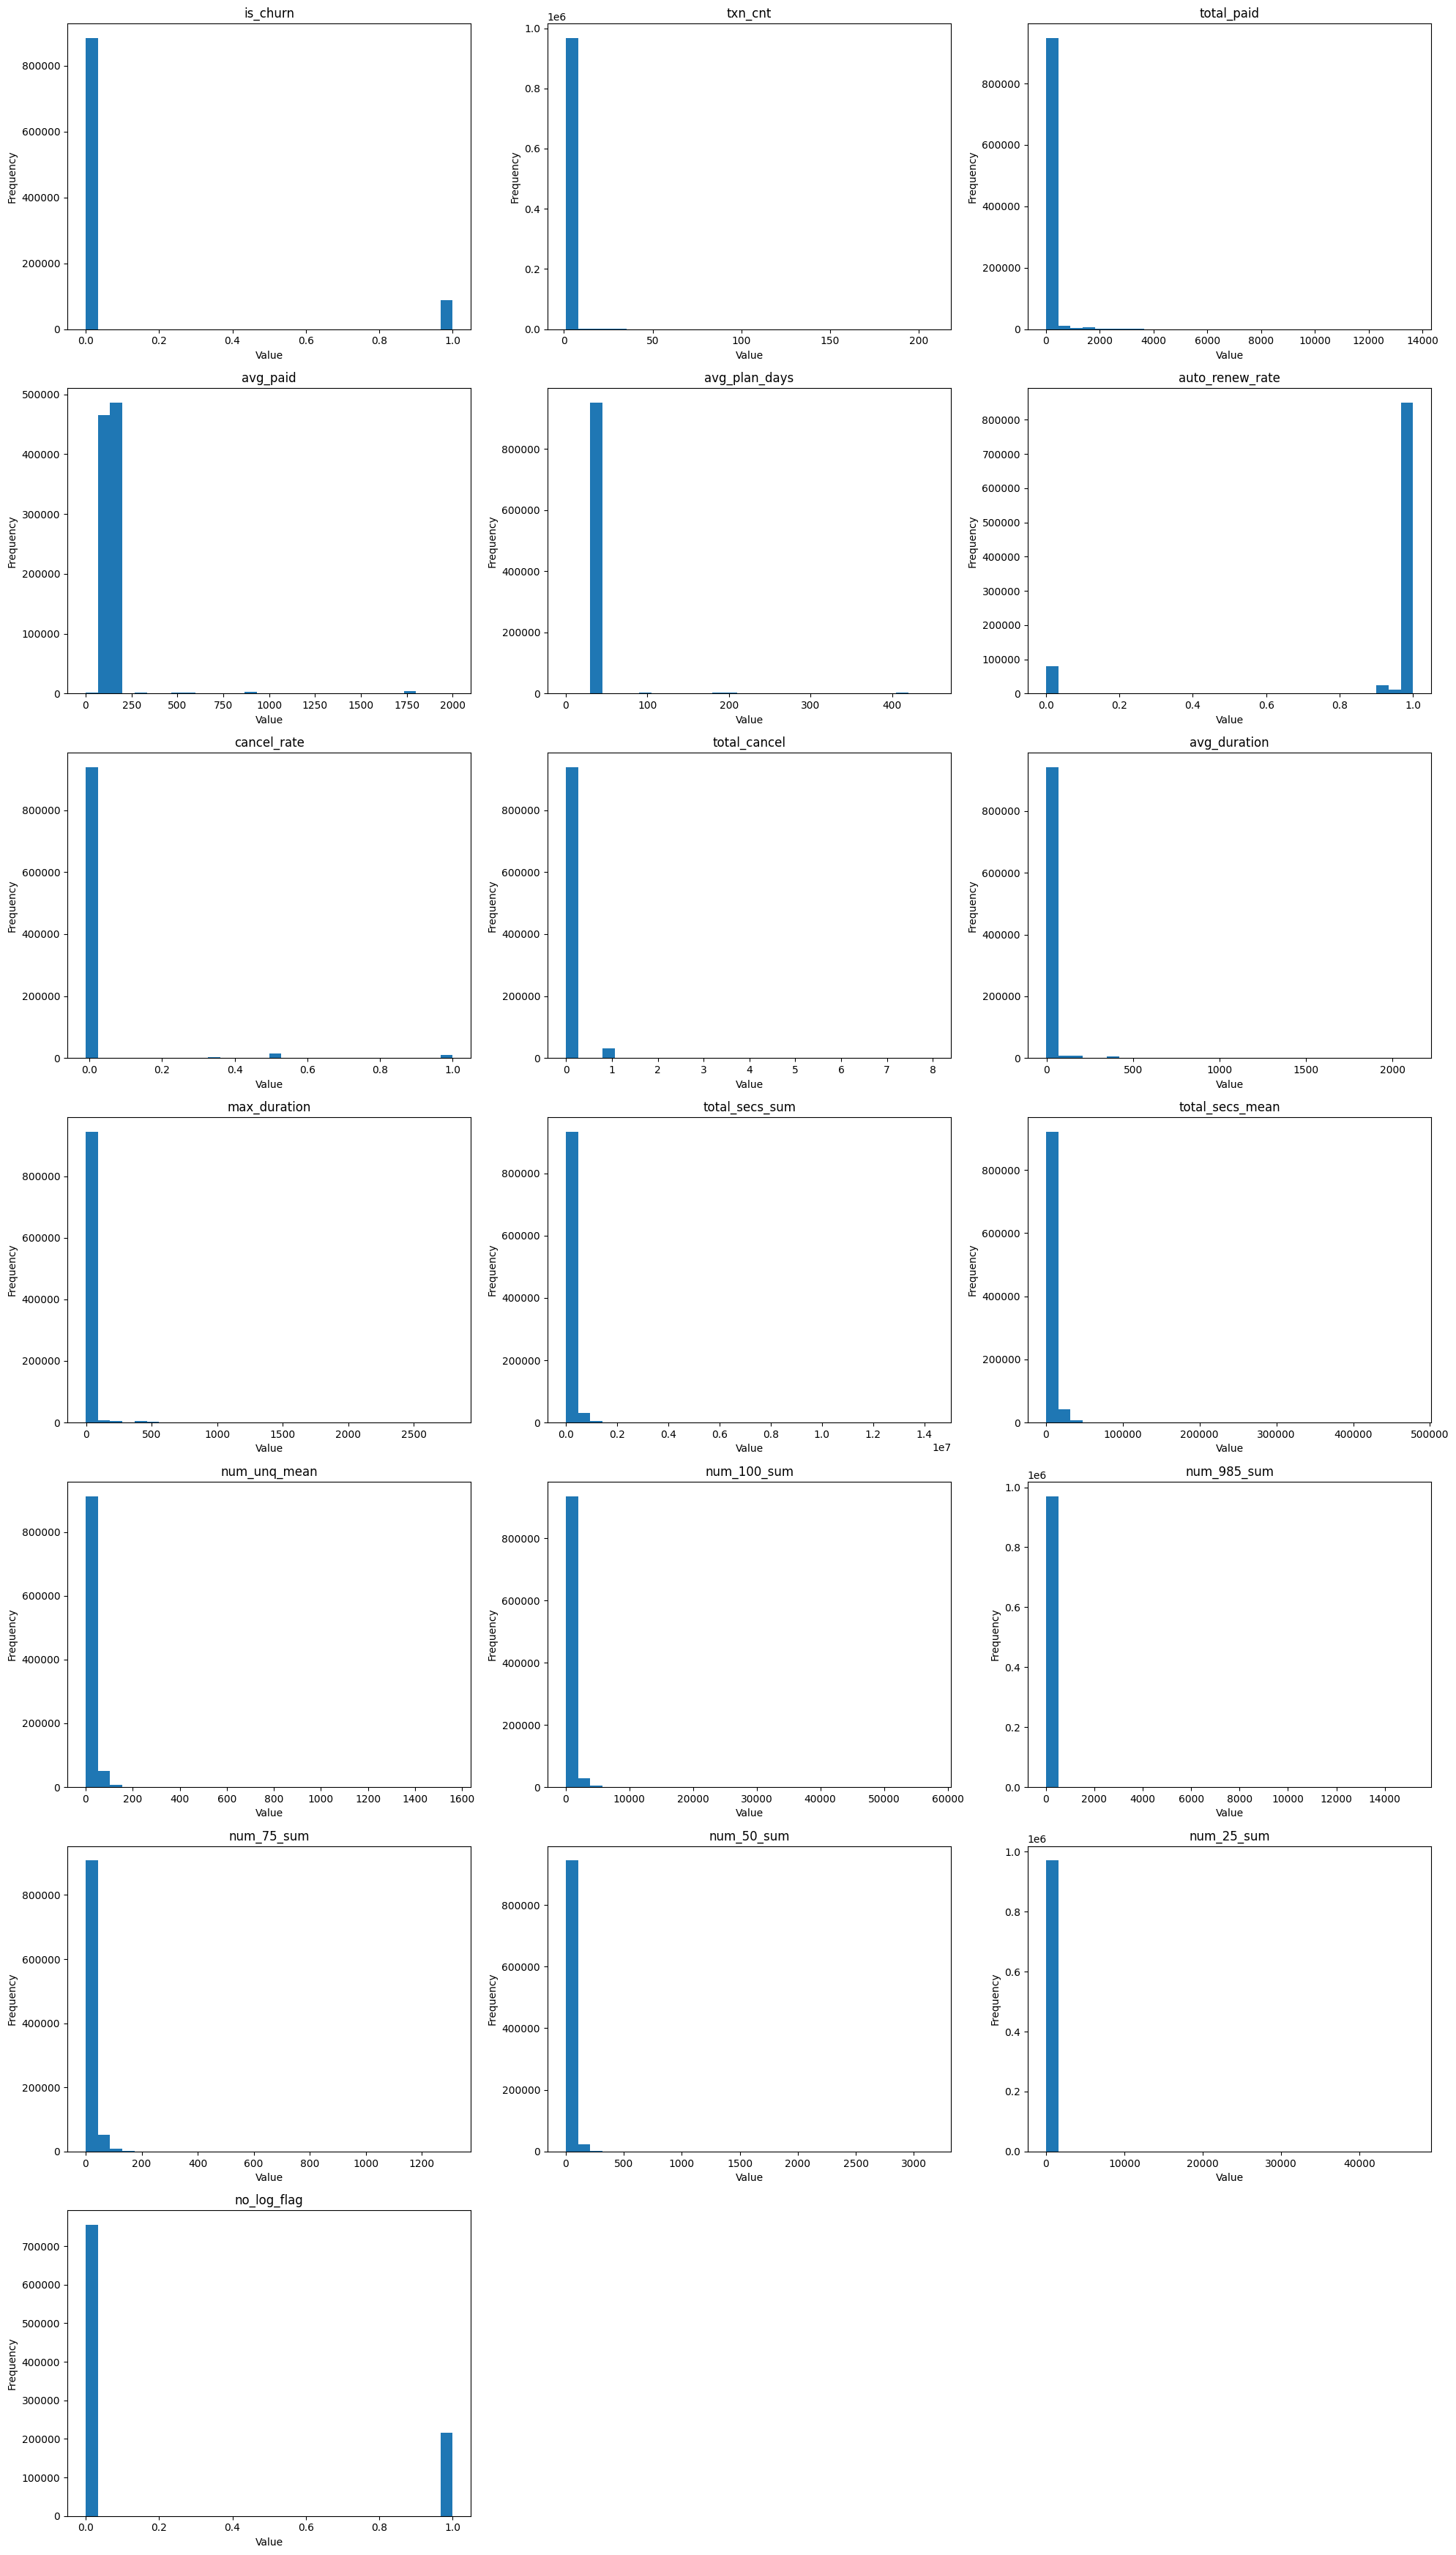

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 수치형 컬럼만 선택
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

n_cols = 3 # 한 줄에 4개씩
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=30)
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# 남는 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\Users\rosie\AppData\Local\Temp\ipykernel_22536\3221222656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(
C:\Users\rosie\AppData\Local\Temp\ipykernel_22536\3221222656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(
C:\Users\rosie\AppData\Local\Temp\ipykernel_22536\3221222656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(
C:\Users\rosie\AppData\Local\Temp\ipykernel_22536\3221222656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3

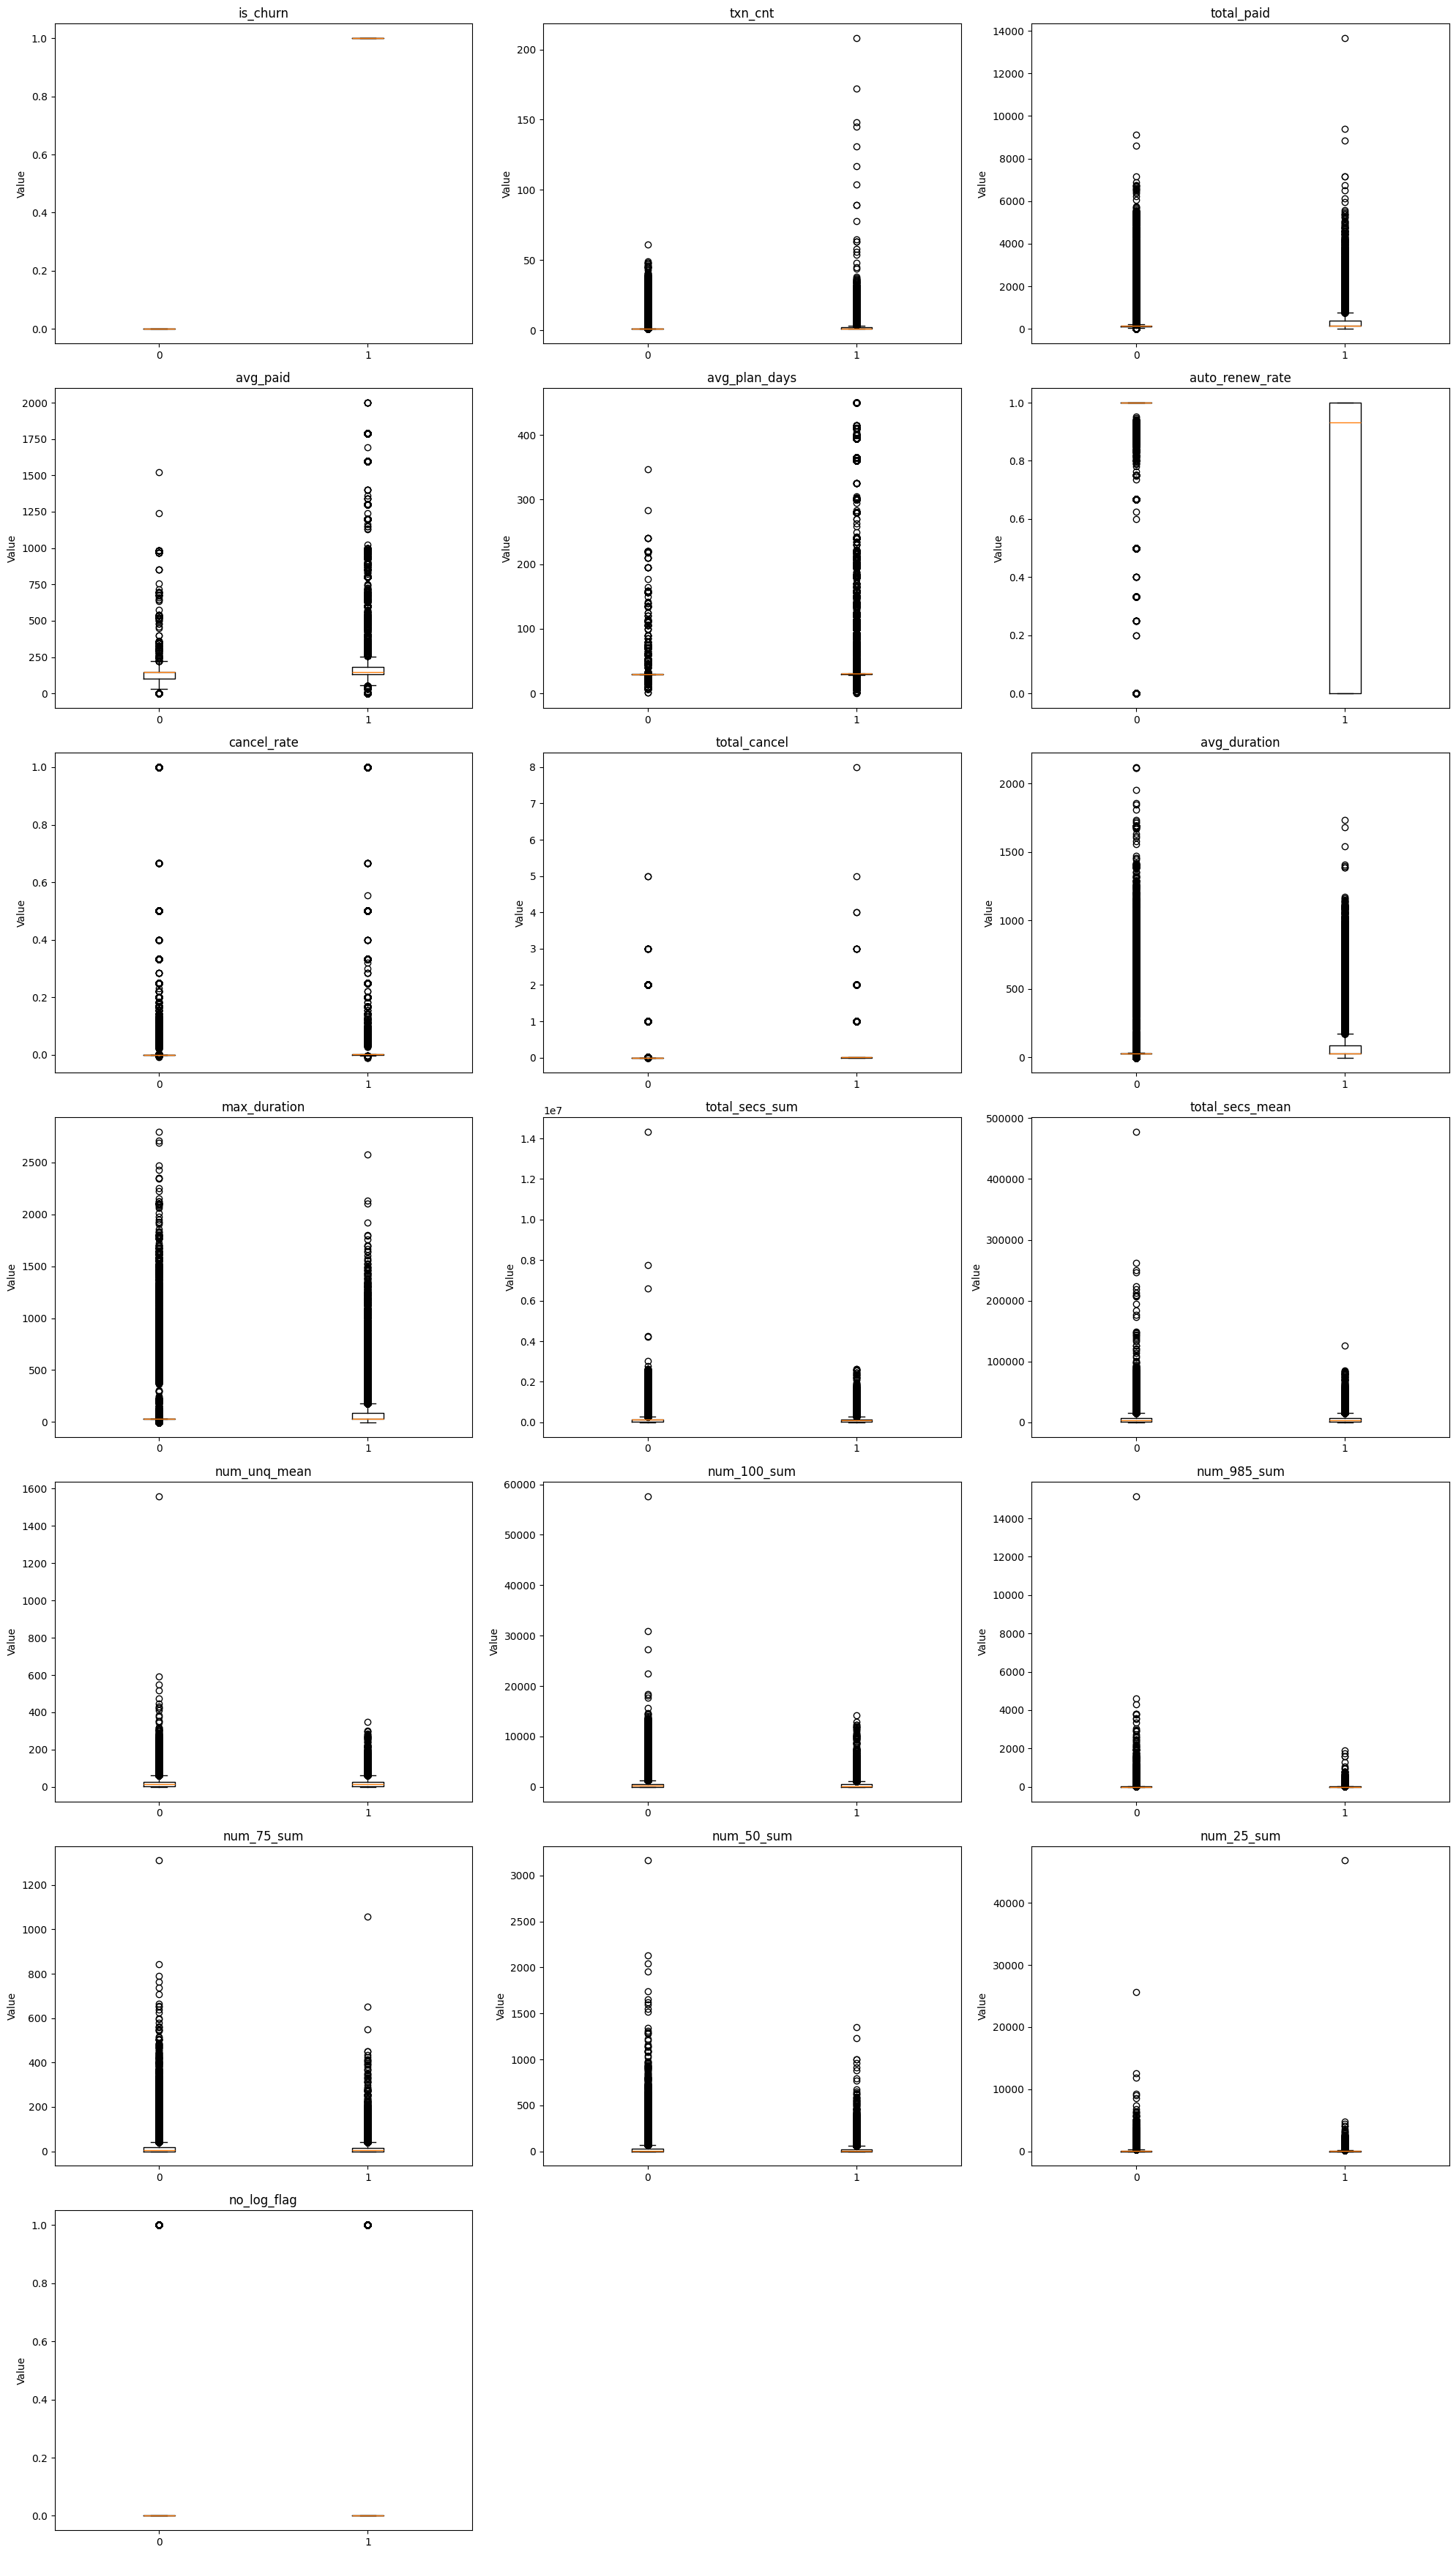

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 수치형 컬럼만 선택
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].boxplot(
        [
            df[df["is_churn"] == 0][col].dropna(),
            df[df["is_churn"] == 1][col].dropna()
        ],
        labels=["0", "1"]
    )
    axes[i].set_title(col)
    axes[i].set_ylabel("Value")

# 남는 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()